In [3]:
"""
!DEPRECATED SCRIPT!: Merges and video-length are based on the raw-uncut videos in this script. 
To have an accurate estimate, we should consider the clip_end-clip-start tied to a unique clip_uid in the annotations.



This analysis is on the merged labeled train/val sets of the LTAA benchmark in ego4d.
Analysis in ego4d_user_vs_action_analysis.ipynb focuses on single splits instead.
"""

# Make sure to: 'pip install ipynb' for iphython function imports
import ipynb.fs.defs.ego4d_LTA_SINGLE_SPLITS_analysis as fn

# Alternatives
# %run 'ego4d_LTA_SINGLE_SPLITS_analysis.ipynb' # Also executes other notebook (also plotting)
# from ipynb.fs.defs.ego4d_LTA_SINGLE_SPLITS_analysis import group_innerjoin_by_user,create_action_labels_from_verbnoun,\
# create_counter_columns,get_normalized_distr_actions,plot_barchart, plot_useractions_stackedbarchart  # Only import functions/classes


import pandas as pd
import numpy as np
from collections import Counter
import os.path as osp
import json
import matplotlib.pyplot as plt
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)       


In [4]:
# Entire dataset Meta-data DF
meta_data_file_path = "/fb-agios-acai-efs/Ego4D/ego4d_data/ego4d.json"
with open(meta_data_file_path, 'r') as meta_data_file:
    meta_data_obj = json.load(meta_data_file)
    
pd.json_normalize(meta_data_obj) # Convert to DF
video_df = pd.json_normalize(meta_data_obj['videos'])

# list(video_df)

# Load train+validation sets

In [5]:
# CHECK CROSS-SPLITS: Are there mutually excl users in each split?
# Test has no labels
annotation_file_dir = "/fb-agios-acai-efs/Ego4D/ego4d_data/v1/annotations"
annotation_file_names = {'train':"fho_lta_train.json",'val':'fho_lta_val.json','test':'fho_lta_test_unannotated.json'}
with open(osp.join(annotation_file_dir, annotation_file_names['train']), 'r') as train_file, \
    open(osp.join(annotation_file_dir, annotation_file_names['val']), 'r') as val_file:
    train_clips = json.load(train_file)['clips']
    val_clips = json.load(val_file)['clips']

train_clips_df = pd.json_normalize(train_clips)
val_clips_df = pd.json_normalize(val_clips)
print(f"trainshape={train_clips_df.shape}")
print(f"valshape={val_clips_df.shape}")

train_joined_df = pd.merge(video_df, train_clips_df, on="video_uid",validate="one_to_many",how="inner") # Inner-join (Intersection of  video-uid values)
val_joined_df = pd.merge(video_df, val_clips_df, on="video_uid",validate="one_to_many",how="inner") # Inner-join (Intersection of  video-uid values)
print(f"train_joined_df={train_joined_df.shape}")
print(f"val_joined_df={val_joined_df.shape}")


train_user_df = fn.group_innerjoin_by_user(train_joined_df)
val_user_df = fn.group_innerjoin_by_user(val_joined_df)
print(f"train_user_df={train_user_df.shape}")
print(f"val_user_df={val_user_df.shape}")

print("Overlap between the val/train users = {}".format(
sum((train_user_df.fb_participant_id.isin(val_user_df.fb_participant_id) == True))
))


trainshape=(23610, 20)
valshape=(15587, 20)
train_joined_df=(23610, 73)
val_joined_df=(15587, 73)
train_user_df=(168, 14)
val_user_df=(144, 14)
Overlap between the val/train users = 115


In [11]:
def summarize_clips_by_user(joined_df):
    clip_df = joined_df.groupby(joined_df['clip_uid'], as_index=False).agg(
        {'fb_participant_id':lambda x: np.unique(x).tolist(),
         'scenarios':list,
         'verb':list,'noun':list, 'verb_label':list, 'noun_label':list, 'action_idx':list,
#          'video_uid':list,'duration_sec':list, # This is the raw uncut video, don't need this info
         'clip_id':list,'clip_parent_start_sec':lambda x: np.unique(x).tolist(),'clip_parent_end_sec':lambda x: np.unique(x).tolist()}) 
    
    # Check users/clip_starts and ends are only 1 unique
    assert (clip_df.fb_participant_id.apply(len) == 1).all()
    assert (clip_df.clip_parent_start_sec.apply(len) == 1).all()
    assert (clip_df.clip_parent_end_sec.apply(len) == 1).all()
    
    # Unpack
    for col_name in ['fb_participant_id','clip_parent_start_sec','clip_parent_end_sec']:
        clip_df[col_name] = clip_df[col_name].apply(lambda x : x[0])
    
    
    # Get clip lengths
    clip_df['clip_duration_sec'] = clip_df.loc[:,('clip_parent_end_sec','clip_parent_start_sec')].apply(lambda x: x[0]-x[1],axis=1)
    
    
    # Merge The clip-usermetadata joined frames and join with the clip_length based on clip_uid
    # Group by fb_participant_id, which has allocated multiple clip_uid
    user_df = clip_df.groupby(clip_df['fb_participant_id'], as_index=False).agg(
        {
#        'fb_participant_id':'first',
         'scenarios':list,
         'verb':list,'noun':list, 'verb_label':list, 'noun_label':list, 'action_idx':list,
#          'video_uid':list,'duration_sec':list, # This is the raw uncut video, don't need this info
         'clip_id':list,'clip_parent_start_sec':list,'clip_parent_end_sec':list, 'clip_duration_sec':list}
    ) # VIDEO UID COUNT IS NOT CORRECT! Also counts non-uniques in join


    user_df['sum_clip_duration_sec'] = user_df['clip_duration_sec'].apply(sum)
    
    
    # Check that no NaN user
    
    
    # The scenarios only apply to the raw uncut video, not the 5min clips
    user_df = user_df.rename(columns={"scenarios":"possible_clip_scenarios"})

    return user_df


user_df = summarize_clips_by_user(train_joined_df)
user_df

,fb_participant_id,possible_clip_scenarios,verb,noun,verb_label,noun_label,action_idx,clip_id,clip_parent_start_sec,clip_parent_end_sec,clip_duration_sec,sum_clip_duration_sec
0,8.0,"[[[Crafting/knitting/sewing/drawing/painting],...","[[paint, put_(place,_leave,_drop), take_(pick,...","[[cardboard_(cardboard,_paperboard), paintbrus...","[[53, 65, 92, 19, 53, 53, 53, 65, 53, 19, 53, ...","[[68, 279, 279, 279, 286, 280, 469, 279, 280, ...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[[1725, 1725, 1725, 1725, 1725, 1725, 1725, 17...",[1192.0],[1319.57],[127.56999999999994],127.570000
1,9.0,"[[[Gardening], [Gardening], [Gardening], [Gard...","[[hold_(support,_grip,_grasp), spray, remove, ...","[[hose, spray_(spray,_sprayer), hose, hose, wa...","[[35, 84, 67, 65, 84, 84, 65, 28, 17, 103, 51,...","[[211, 391, 211, 211, 457, 457, 211, 211, 211,...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[[2372, 2372, 2372, 2372, 2372, 2372, 2372, 23...","[0.0, 292.0]","[308.0, 608.0]","[308.0, 316.0]",624.000000
2,10.0,"[[[Car/scooter washing], [Car/scooter washing]...","[[clean_(sweep,_scrub,_mop,_dust), clean_(swee...","[[floor_(floor,_ground), rod_(dipstick,_rod,_r...","[[9, 9, 100, 67, 65, 49, 101, 42, 65, 9, 9, 9,...","[[158, 334, 409, 334, 334, 334, 409, 447, 198,...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[[588, 588, 588, 588, 588, 588, 588, 588, 588,...","[292.0, 1192.0, 0.0, 292.0, 892.0, 0.0, 292.0,...","[608.0, 1253.2510286458335, 308.0, 608.0, 1208...","[316.0, 61.25102864583346, 308.0, 316.0, 316.0...",2797.251029
3,11.0,"[[[Household management - caring for kids], [H...","[[clean_(sweep,_scrub,_mop,_dust), clean_(swee...","[[wood_(fiber,_firewood,_floorboard,_log,_lumb...","[[9, 9, 65, 9], [98, 19, 60, 98, 98, 53, 19, 6...","[[469, 469, 343, 469], [10, 279, 279, 10, 10, ...","[[0, 1, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...","[[2632, 2632, 2632, 2632], [2615, 2615, 2615, ...","[892.0, 592.0, 0.0]","[1208.0, 908.0, 47.1333]","[316.0, 316.0, 47.1333]",679.133300
4,12.0,"[[[Crafting/knitting/sewing/drawing/painting],...","[[take_(pick,_grab,_get), apply_(spread,_smear...","[[cardboard_(cardboard,_paperboard), cardboard...","[[92, 1, 16, 1, 92, 35, 92, 16, 65, 16, 65, 1,...","[[68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, ...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[[1759, 1759, 1759, 1759, 1759, 1759, 1759, 17...","[1192.0, 892.0]","[1508.0, 1101.1510286458335]","[316.0, 209.15102864583355]",525.151029
...,...,...,...,...,...,...,...,...,...,...,...,...
163,462.0,[[[jobs related to construction/renovation com...,"[[turn_on_(switch_on,_start,_light), put_(plac...","[[cigarette_(cigarette,_vape), lighter, contai...","[[101, 65, 65, 92, 3, 99, 50, 3, 27, 35, 50, 3...","[[91, 235, 105, 36, 36, 462, 448, 322, 322, 46...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[[3338, 3338, 3338, 3338, 3338, 3338, 3338, 33...","[0.0, 0.0]","[183.1, 308.0]","[183.1, 308.0]",491.100000
164,463.0,"[[[Crafting/knitting/sewing/drawing/painting],...","[[cut_(trim,_slice,_chop), put_(place,_leave,_...","[[picture_(picture,_portrait), picture_(pictur...","[[16, 65, 92, 16, 65, 61]]","[[304, 304, 349, 304, 349, 300]]","[[0, 1, 2, 3, 4, 5]]","[[1561, 1561, 1561, 1561, 1561, 1561]]",[0.0],[308.0],[308.0],308.000000
165,464.0,[[[jobs related to construction/renovation com...,"[[tighten, hold_(support,_grip,_grasp), hold_(...","[[screw_(bolt,_nail,_screw), mower_(lawnmower,...","[[96, 35, 35, 34, 64, 96, 78, 50, 11, 92, 35, ...","[[352, 259, 259, 259, 259, 259, 259, 134, 134,...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[[3360, 3360, 3360, 3360, 3360, 3360, 3360, 33...",[292.0],[608.0],[316.0],316.000000
166,465.0,[[[jobs related to construction/renovation com...,"[[pour, scoop, pour, scoop, pour, put_(place,_...","[[soil_(dirt,_mud,_soil), soil_(dirt,_mud,_soi...","[[60, 71, 60, 71, 60, 65, 42, 64, 65, 35, 64, ...","[[379, 379, 379, 379, 379, 366, 71, 71, 439, 7...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9,

# Prepare dataframe summarizing columns

In [6]:
# Prep the train-val DF 

# Let's merge train/val
trainval_joined_df = pd.concat([train_joined_df, val_joined_df], ignore_index=True, sort=False) # 312 rows × 12 columns
trainval_user_df = fn.group_innerjoin_by_user(trainval_joined_df)

# Prepare counts/distributions etc in DF columns
trainval_user_counter_df = trainval_user_df.copy(deep=True)
fn.create_action_labels_from_verbnoun(trainval_user_counter_df) # Create action labels by merging verbnouns
fn.create_counter_columns(trainval_user_counter_df) # Apply counter objects on action columns
fn.get_normalized_distr_actions(trainval_user_counter_df)


# Total nb of different actions IN GENERAL (user-agnostic)
print(f"UNIQUE ACTIONS in the trainval subset: {len(set(np.concatenate(trainval_user_counter_df['action_label'].tolist())))}") # 4433 unique actions
print(f"UNIQUE SCENARIOS in the trainval subset: {len(set(np.concatenate(trainval_user_counter_df['scenarios'].tolist())))}")
print(trainval_user_counter_df.head(n=20))


Created action_label column
Created action column
Created column Counter: action_label
Created column Counter: action
542
UNIQUE ACTIONS in the trainval subset: 4433
UNIQUE SCENARIOS in the trainval subset: 44
    fb_participant_id                                          scenarios  \
0                 8.0  [Crafting/knitting/sewing/drawing/painting, Cr...   
1                 9.0  [Playing cards, Playing cards, Playing cards, ...   
2                10.0  [Household management - caring for kids, House...   
3                11.0  [Household management - caring for kids, House...   
4                12.0  [Crafting/knitting/sewing/drawing/painting, Cr...   
5                13.0  [Crafting/knitting/sewing/drawing/painting, Cr...   
6                14.0  [Crafting/knitting/sewing/drawing/painting, Cr...   
7                15.0  [Car/scooter washing, Car/scooter washing, Car...   
8                16.0  [Cleaning / laundry, Cleaning / laundry, Clean...   
9                17.0  [Farmer

# Action distributions summarized per user
Warning: This may take several minutes! Many actions are being stacked.

In [7]:
show_plots = False
if show_plots:
    trainval_video_lens_s = fn.plot_useractions_stackedbarchart(
        trainval_user_counter_df,sort_by_col="duration_sec_sum",y_col="action_distr")

    # Plot video total lengths
    y_axis = [int(x/60) for x in trainval_video_lens_s]
    x_axis = [idx for idx in range(len(trainval_video_lens_s))]
    fn.plot_barchart(x_axis, y_axis, title='Video length (min) per user - TRAINVAL',ylabel='Video length (min)',xlabel="user")

    # Plot cumulative
    y_axis = [int(x/60) for x in np.cumsum(trainval_video_lens_s)]
    x_axis = [idx for idx in range(len(trainval_video_lens_s))]
    fn.plot_barchart(x_axis, y_axis, title='Cumm Video length (min) per user - TRAINVAL',ylabel='Video length (min)',xlabel="user")
    print(y_axis)

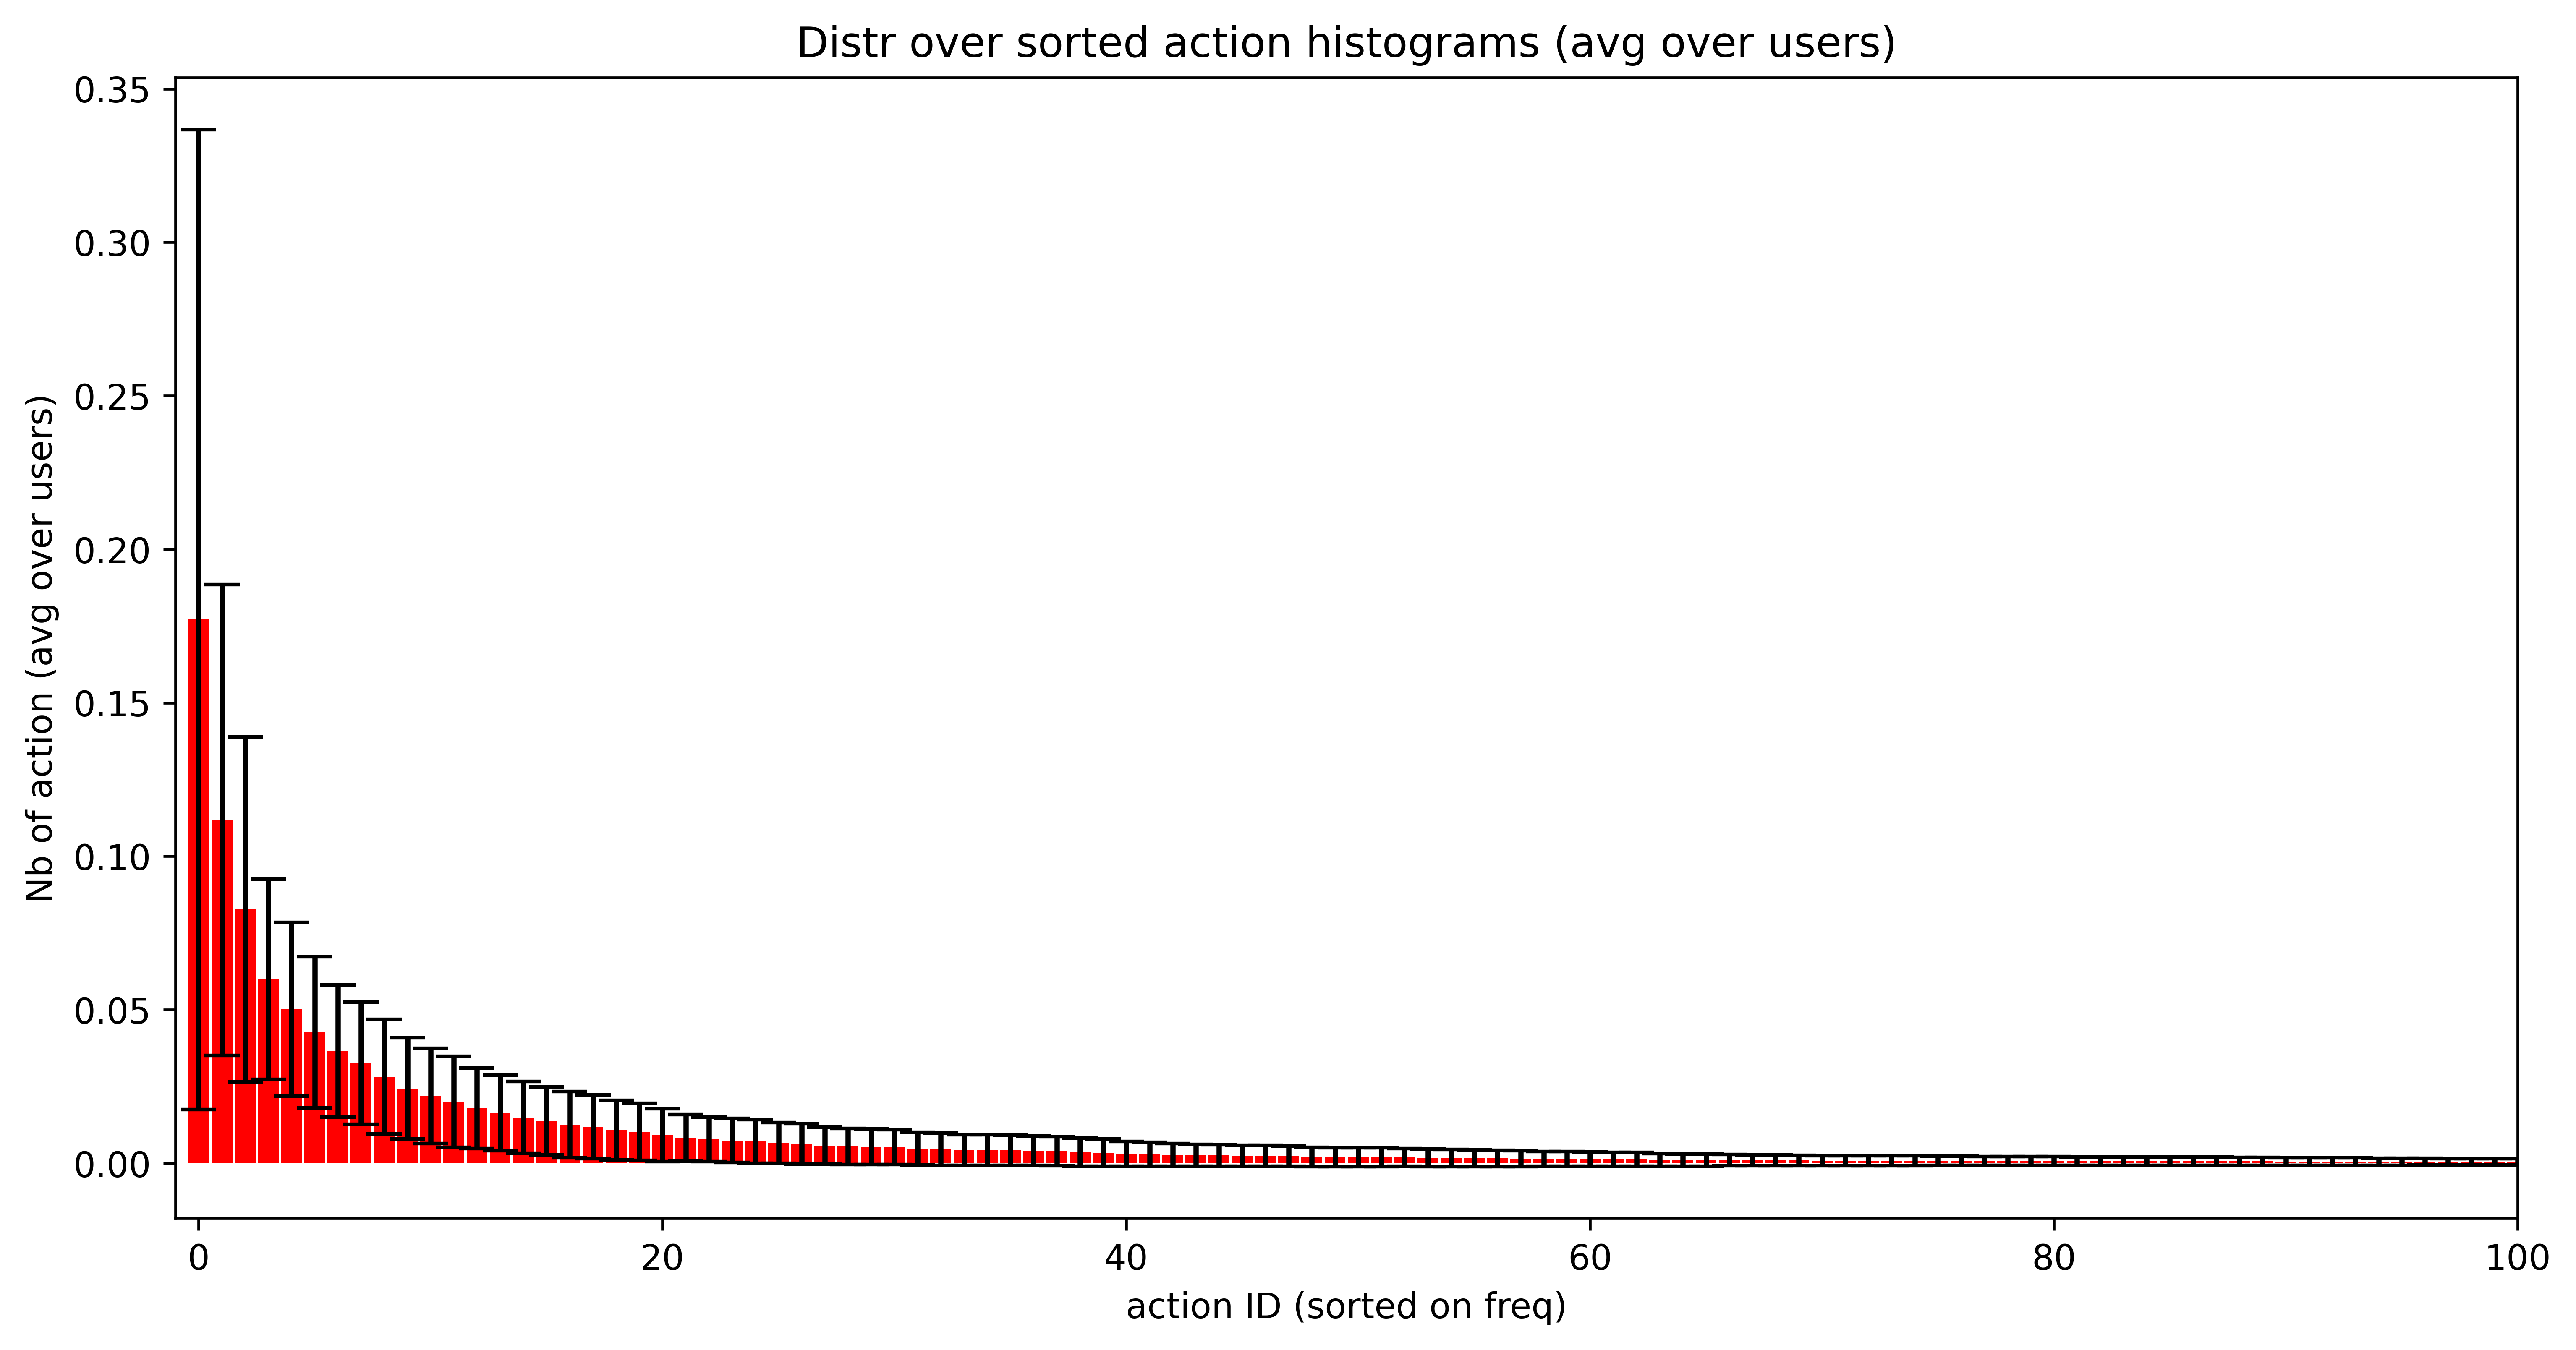

VALS = ['17.710', '11.181', '8.269', '5.997', '5.012', '4.269', '3.654', '3.257', '2.818', '2.434', '2.189', '1.998', '1.789', '1.641', '1.491', '1.378', '1.256', '1.190', '1.078', '1.022', '0.918', '0.823', '0.775', '0.740', '0.712', '0.660', '0.631', '0.571', '0.544', '0.537', '0.520', '0.479', '0.459', '0.434', '0.430', '0.424', '0.405', '0.391', '0.358', '0.344', '0.309', '0.296', '0.275', '0.264', '0.252', '0.241', '0.241', '0.232', '0.207', '0.199', '0.198', '0.198', '0.183', '0.175', '0.170', '0.164', '0.158', '0.150', '0.140', '0.139', '0.132', '0.126', '0.126', '0.109', '0.106', '0.104', '0.099', '0.094', '0.092', '0.088', '0.085', '0.085', '0.084', '0.084', '0.084', '0.077', '0.074', '0.071', '0.070', '0.070', '0.070', '0.067', '0.065', '0.064', '0.064', '0.062', '0.062', '0.062', '0.061', '0.061', '0.057', '0.056', '0.055', '0.052', '0.051', '0.050', '0.048', '0.046', '0.044', '0.044', '0.044', '0.044', '0.041', '0.037', '0.035', '0.033', '0.033', '0.033', '0.032', '0.032', 

<Figure size 432x288 with 0 Axes>

In [8]:
# Action distr histogram

# Barchart API: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html#matplotlib.pyplot.bar
def plot_histogram(x_axis, y_axis, title,ylabel,xlabel='User-ID', grid=False,yerror=None):
    max_val = max(y_axis)
    my_cmap = plt.get_cmap("plasma")
    plt.figure(figsize=(12, 6), dpi=600) # So all bars are visible!
    plt.bar(x_axis, height=y_axis,color='red', align='center', capsize=5,yerr=yerror,width=0.9)
    plt.ylim(None,None)
    plt.xlim(-1,100)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(grid)
    plt.show()
    plt.clf()
    
    print(f"VALS = {['{:.3f}'.format(x*100) for x in y_axis]}")
    



# Get mean and std
histogram_means = trainval_user_counter_df['action_distr'].mean()
histogram_stds = pd.DataFrame(trainval_user_counter_df['action_distr'].tolist(), index=trainval_user_counter_df.index).std().tolist()
# print(f"{len(histogram_means)}: {histogram_means}")
# print(f"{len(histogram_stds)}: {histogram_stds}")


x_axis_scenario_ids = list(range(len(histogram_means)))
plot_histogram(x_axis_scenario_ids, histogram_means, 
              yerror=histogram_stds,
              title="Distr over sorted action histograms (avg over users)",
             ylabel="Nb of action (avg over users)",xlabel="action ID (sorted on freq)")


# Total action distr in train-val
Warning: This may take several minutes! Many actions are being stacked.

Created action_label column
Created action column
Plotting, make take several minutes due to 4k acitons


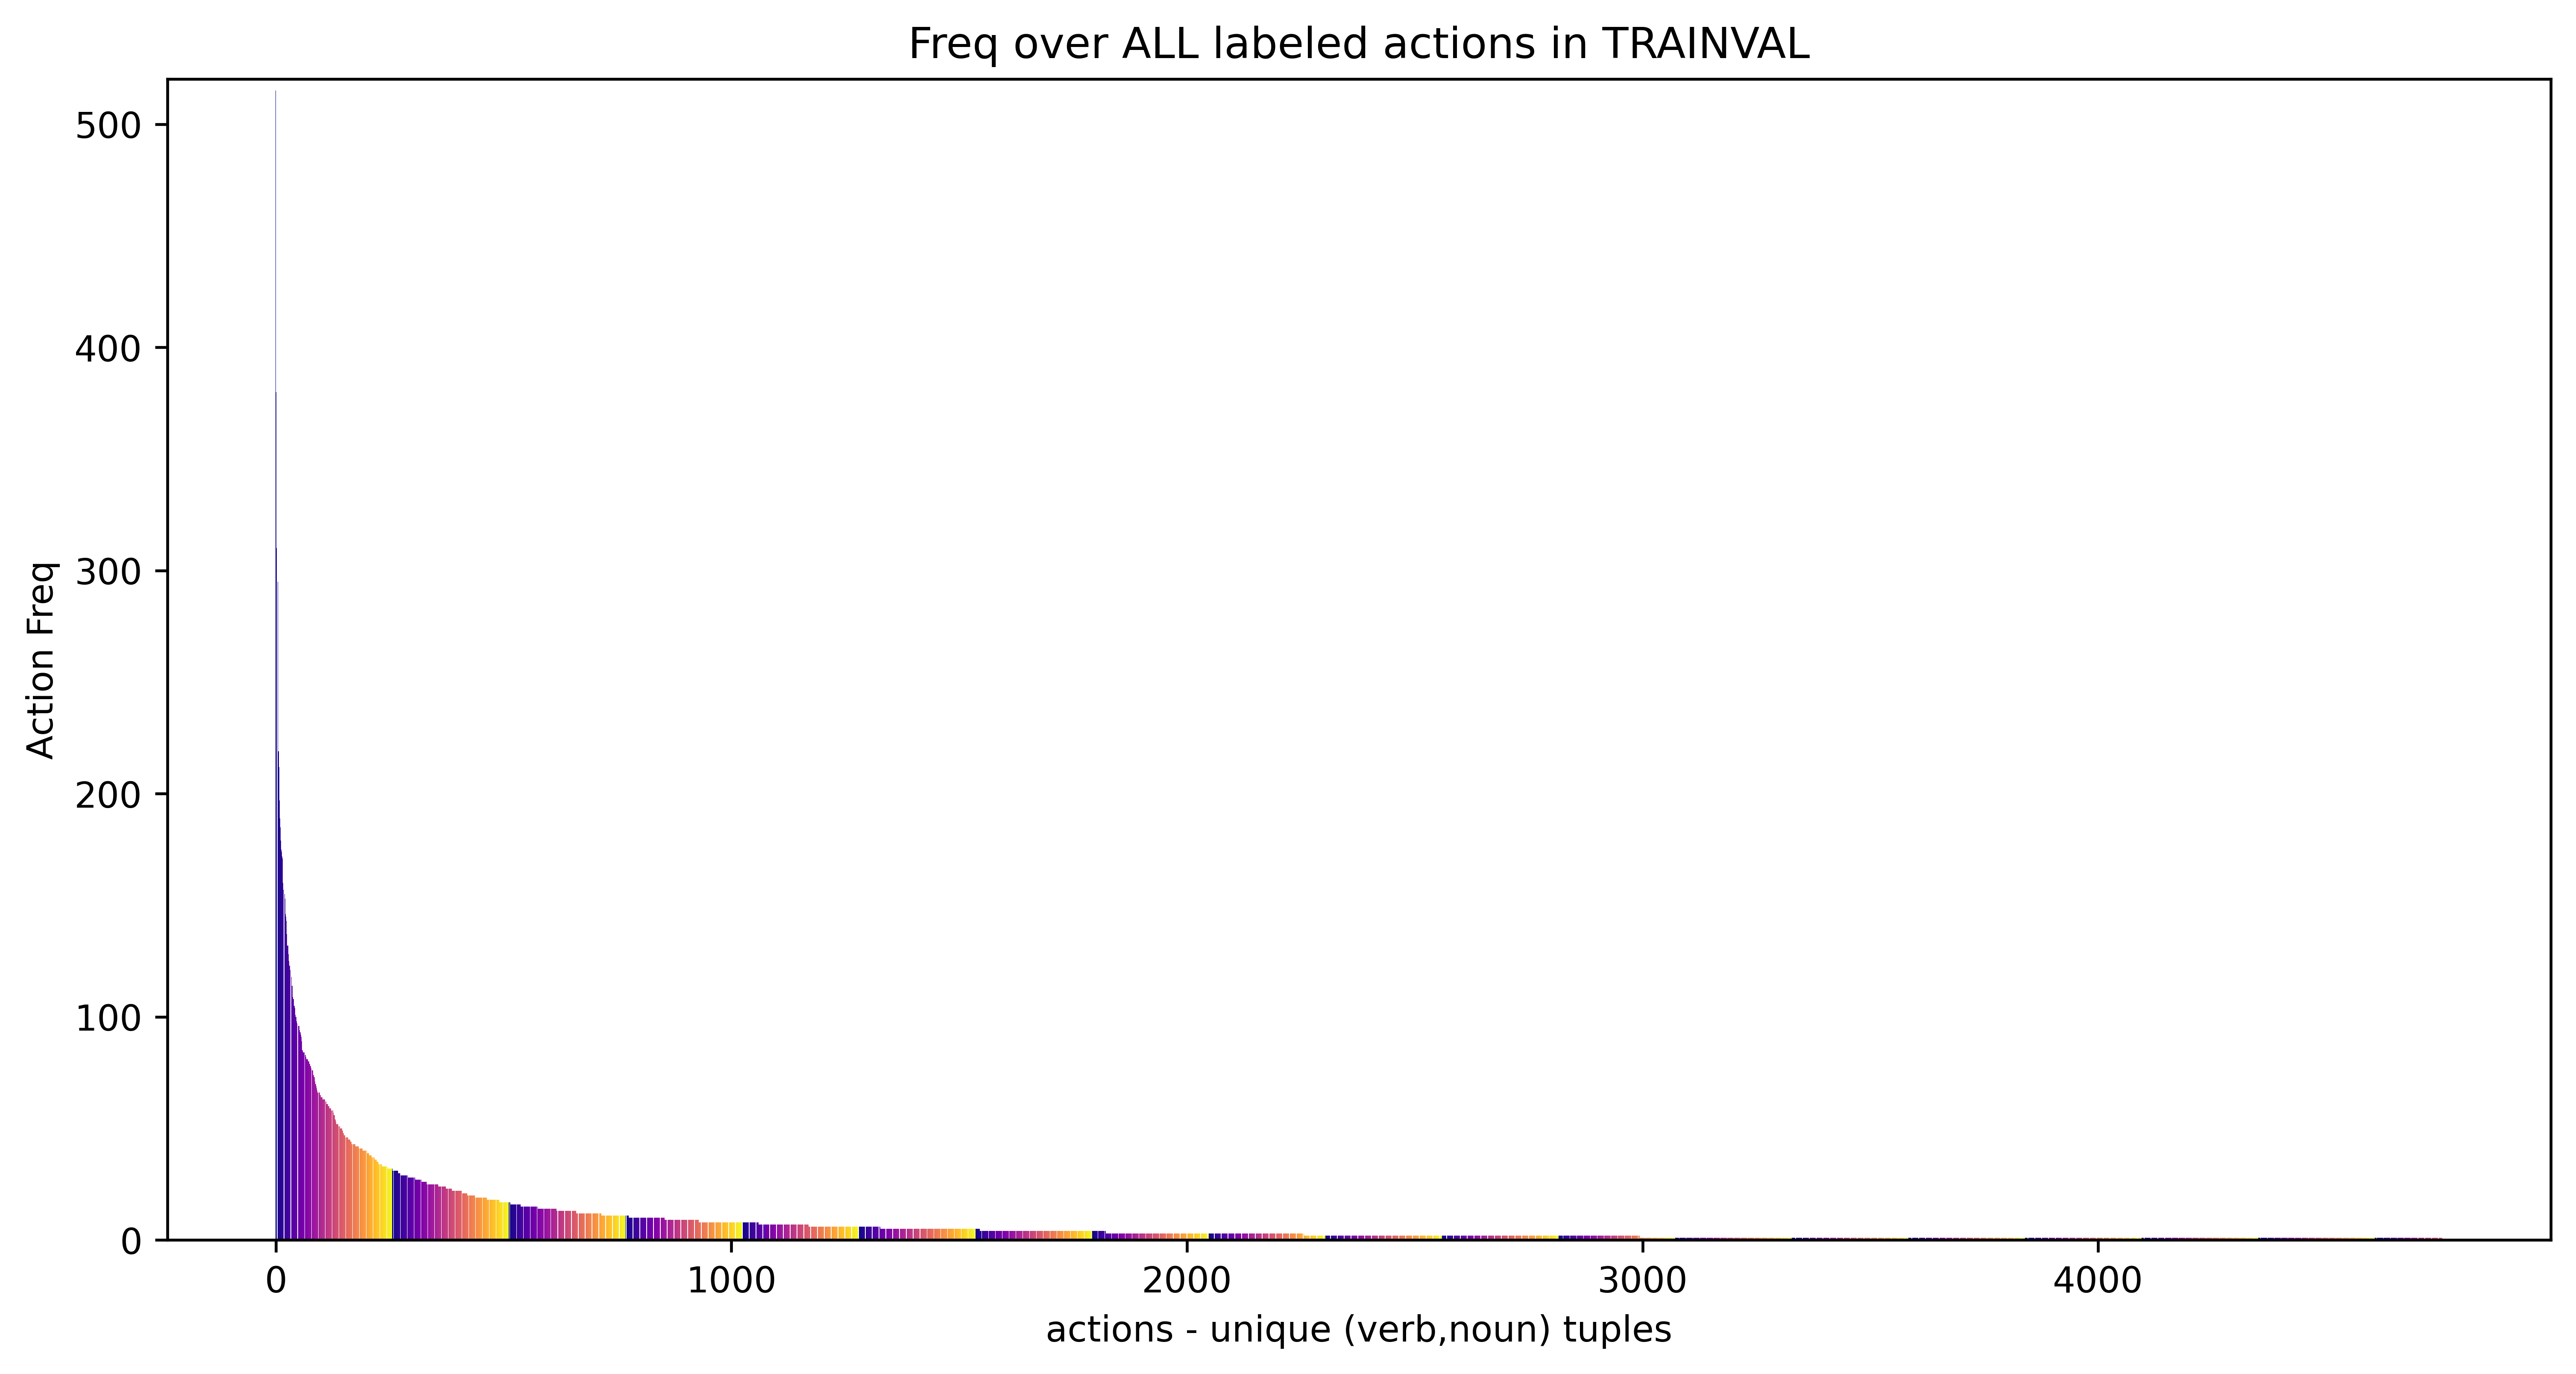

HEAD = [515, 380, 310, 301, 295, 219, 219, 212, 197, 189]...
TAIL = ...[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


<Figure size 432x288 with 0 Axes>

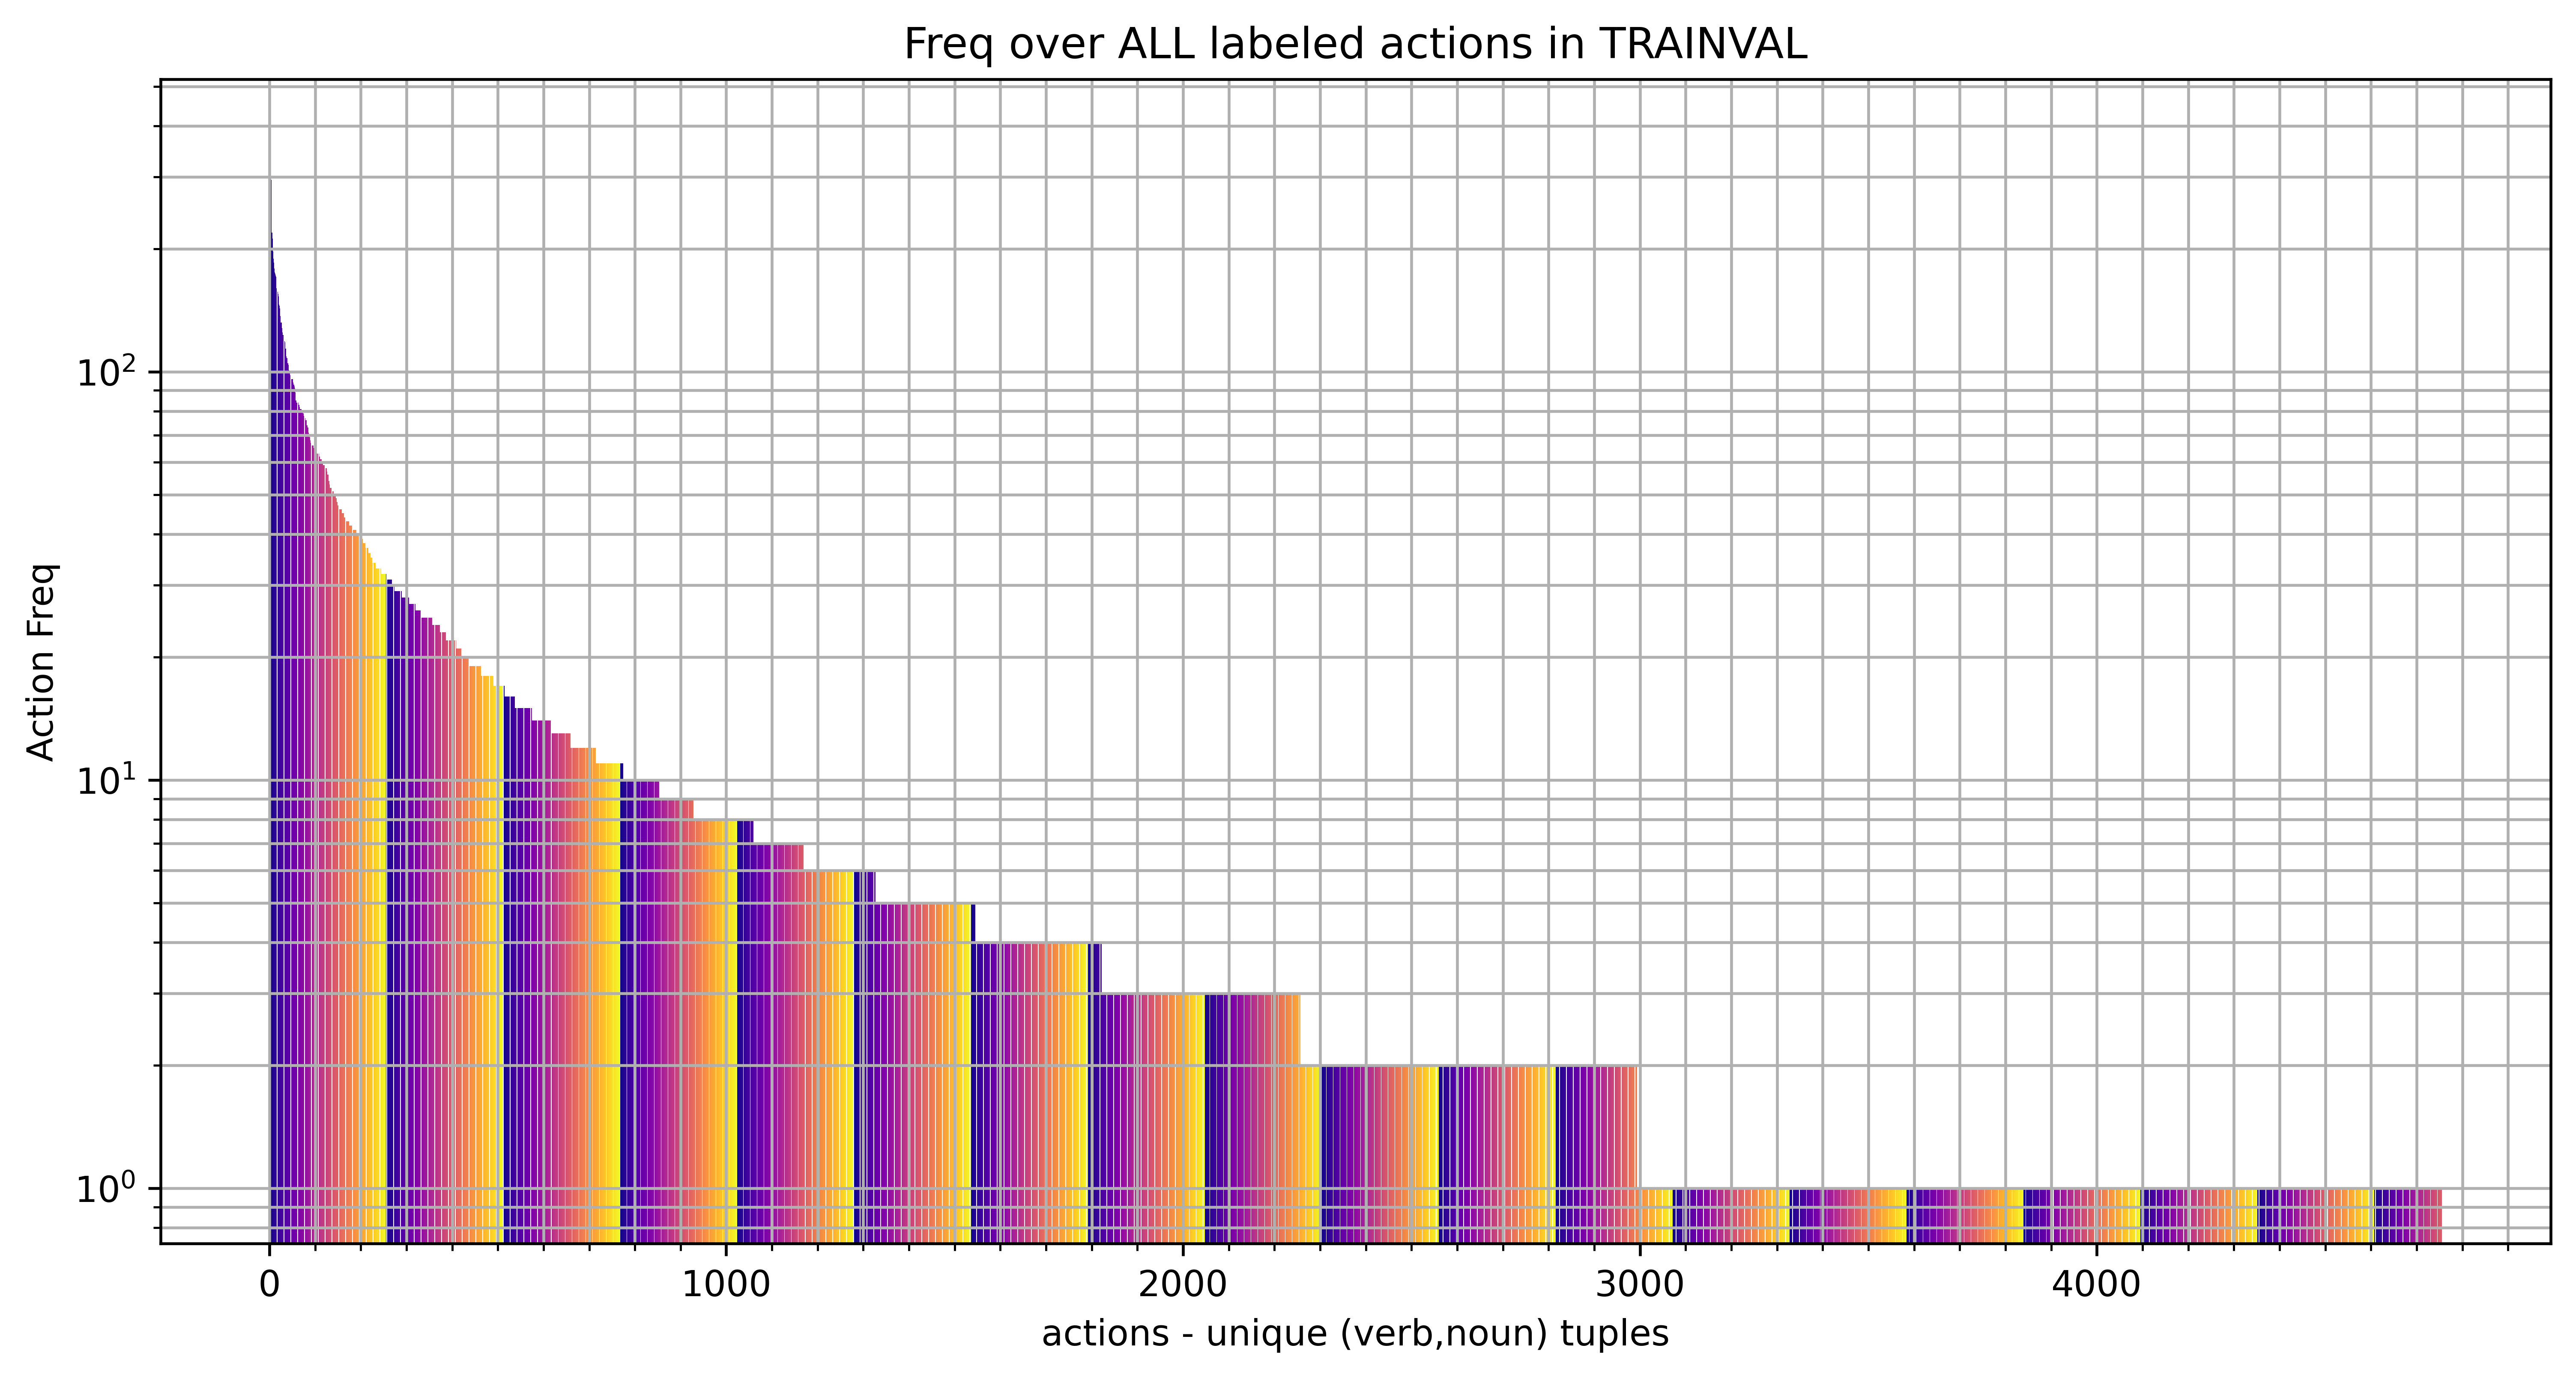

HEAD = [515, 380, 310, 301, 295, 219, 219, 212, 197, 189]...
TAIL = ...[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
HEAD ACTIONS:
['put_(place,_leave,_drop)-dough',
 'put_(place,_leave,_drop)-container_(box,_can,_carton,_case,_casing,_container,_crate,_holder,_jar,_jerrycan,_keg,_pack,_package,_packaging,_packet,_storage,_tank,_tin)',
 'put_(place,_leave,_drop)-wood_(fiber,_firewood,_floorboard,_log,_lumber,_plank,_plywood,_timber,_wood,_woodcraft,_woodwork)',
 'take_(pick,_grab,_get)-dough',
 'take_(pick,_grab,_get)-container_(box,_can,_carton,_case,_casing,_container,_crate,_holder,_jar,_jerrycan,_keg,_pack,_package,_packaging,_packet,_storage,_tank,_tin)',
 'take_(pick,_grab,_get)-wood_(fiber,_firewood,_floorboard,_log,_lumber,_plank,_plywood,_timber,_wood,_woodcraft,_woodwork)',
 'put_(place,_leave,_drop)-cloth_(cloth,_fabric,_garment,_kanga,_rag)',
 'take_(pick,_grab,_get)-cloth_(cloth,_fabric,_garment,_kanga,_rag)',
 'put_(place,_leave,_drop)-brick',
 'dip-paintbrush',
 'put_(place,_leave,_dro

<Figure size 432x288 with 0 Axes>

In [7]:
# Total distr over actions, use annotations DF
trainval_clips_df = pd.concat([train_clips_df, val_clips_df], ignore_index=True, sort=False) 
fn.create_action_labels_from_verbnoun(trainval_clips_df) # Create action labels by merging verbnouns

# Count action totals
total_action_id_counts = Counter(trainval_clips_df['action_label'].tolist())
total_action_id_counts_s = sorted([(value,key) for key,value in total_action_id_counts.items()],reverse=True)
total_action_name_counts = Counter(trainval_clips_df['action'].tolist())
total_action_name_counts_s = sorted([(value,key) for key,value in total_action_name_counts.items()],reverse=True)
total_action_name_counts_s

x_labels_total = [x[1] for x in total_action_name_counts_s]
y_axis = [x[0] for x in total_action_id_counts_s]      
x_axis = [idx for idx in range(len(total_action_id_counts_s))]

print(f"Plotting, make take several minutes due to 4k acitons")
fn.plot_barchart(x_axis, y_axis, title='Freq over ALL labeled actions in TRAINVAL',ylabel='Action Freq',xlabel="actions - unique (verb,noun) tuples",x_labels=None,bar_align='center')


fn.plot_barchart(x_axis, y_axis, x_minor_ticks=np.arange(0,5000,100),
                 title='Freq over ALL labeled actions in TRAINVAL',ylabel='Action Freq',xlabel="actions - unique (verb,noun) tuples",x_labels=None,bar_align='center',log=True,grid=True)

print(f"HEAD ACTIONS:")
from pprint import pprint
pprint(x_labels_total[:20])

In [8]:
# Make vertical plot
plot = False
if plot:
    # Get labels
    label_len_cutoff =  20
    x_labels_total = [x[:label_len_cutoff] + "..." if len(x) > label_len_cutoff else x for x in x_labels_total] # Cutoff long labels

    keep_label_freq = 500
    x_labels = []
    for idx, label in enumerate(x_labels_total): # Filter, only keep every freq
        x_labels.append(label if idx % keep_label_freq == 0 else None)

    # Make reversed plot
    fn.plot_barchart(y_axis, x_axis, title='Freq over ALL labeled actions in TRAINVAL',xlabel='Action Freq',ylabel="actions - unique (verb,noun) tuples",y_labels=x_labels,bar_align='center',barh=True,figsize=(6,30))
    # print(x_labels)

    # from pprint import pprint
    # pprint(x_labels)



In [9]:
# Make INTERACTIVE plot
# See: https://stackoverflow.com/questions/50560525/how-to-annotate-the-values-of-x-and-y-while-hovering-mouse-over-the-bar-graph/50560826#50560826
# For scatter/line plot: https://stackoverflow.com/questions/7908636/how-to-add-hovering-annotations-to-a-plot

# Install:
# conda install -c conda-forge ipympl
# pip install ipympl
interactive_plot = False
if interactive_plot:
    %matplotlib widget
    # TODO fix back-end: https://stackoverflow.com/questions/52703190/cannot-change-to-a-different-gui-toolkit-notebook-warning-in-jupyter
    fn.plot_barchart(x_axis, y_axis, interactive=True, title='Freq over ALL labeled actions in TRAINVAL',ylabel='Action Freq',xlabel="actions - unique (verb,noun) tuples",x_labels=x_labels_total,bar_align='center')


# User distribution PER ACTION in train-val
Warning: This may take several minutes! Many actions are being stacked.
4k actions on x-axis sorted on total action frequency, for each, the colors indicate how many actions are from the same user.

In [10]:
# PER action get the user distribution
# 4k actions on x-axis, for each, the colors indicate how many actions are from the same user.

# Sort on action frequency

def group_innerjoin_by_action(innerjoined_df):
        action_df = innerjoined_df.copy(deep=True).groupby(innerjoined_df['action_label'], as_index=False).agg(
        {'action':'first', 'fb_participant_id':list,'scenarios':list,'verb':list,'noun':list, 'verb_label':list, 'noun_label':list,
         'video_uid':list,'duration_sec':list,'clip_id':list,'action_idx':list}) # Action and action-label are same, so take first

        action_df['duration_sec_sum'] = action_df.loc[:,('video_uid','duration_sec')].apply(fn.duration_row_fn, axis=1)
        action_df['video_count'] = action_df['video_uid'].apply(lambda x: len(np.unique(x))) # BUGFIX: we need only UNIQUE video_uids after inner_join
        action_df['user_count'] = action_df['fb_participant_id'].apply(lambda x: len(np.unique(x))) # Could take any of the lists
        action_df['scenarios'] = action_df['scenarios'].apply(np.concatenate) # FLATTEN
        action_df['action_count'] = action_df['action_idx'].apply(lambda x:len(x)) # Could take any of the lists

        action_df.drop('duration_sec', axis=1, inplace=True) # Make sure we don't use this one further on
        return action_df
    
# Let's merge train/val
trainval_action_joined_df = pd.concat([train_joined_df, val_joined_df], ignore_index=True, sort=False) # 312 rows × 12 columns

# Summarize NAN USERS
nan_user_actions = trainval_action_joined_df[pd.isnull(trainval_action_joined_df['fb_participant_id'])]
print(f"NAN USERS: {nan_user_actions.shape} out of {trainval_action_joined_df.shape} ({nan_user_actions.shape[0]/trainval_action_joined_df.shape[0]*100})")

# FILTER OUT NAN USERS
trainval_action_joined_df = trainval_action_joined_df[~pd.isnull(trainval_action_joined_df['fb_participant_id'])]
print(f"Remaining entries with non-NAN users: {trainval_action_joined_df.shape}")
# Create action column and group by unique action
fn.create_action_labels_from_verbnoun(trainval_action_joined_df) # Create action labels by merging verbnouns
action_df = group_innerjoin_by_action(trainval_action_joined_df)

# Get stats over users with counters
fn.create_counter_columns(action_df,cols=('fb_participant_id',)) # Counter object on user lists
fn.get_normalized_distr_actions(action_df,target_col='fb_participant_id_count',new_col='fb_participant_id_distr')

action_df

NAN USERS: (4485, 73) out of (39197, 73) (11.442202209352757)
Remaining entries with non-NAN users: (34712, 73)
Created action_label column
Created action column
Created column Counter: fb_participant_id
77


,action,fb_participant_id,scenarios,verb,noun,verb_label,noun_label,video_uid,clip_id,action_idx,duration_sec_sum,video_count,user_count,action_count,fb_participant_id_count,fb_participant_id_distr
0,"adjust_(regulate,_increase/reduce,_change)-bag...","[31.0, 283.0, 33.0, 33.0, 33.0, 33.0, 51.0, 12...","[Cleaning / laundry, biology experiments, Hous...","[adjust_(regulate,_increase/reduce,_change), a...","[bag_(bag,_grocery,_nylon,_polythene,_pouch,_s...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...","[1da766ee-3e09-4e46-9e0c-37b9919c1131, 689848c...","[1033, 3264, 2642, 2642, 2642, 2642, 656, 2510...","[11, 9, 0, 3, 8, 33, 17, 49, 6, 7, 37, 40, 10,...",36638.14,19,19,27,"{31.0: 1, 283.0: 1, 33.0: 4, 51.0: 1, 120.0: 1...","[0.14814814814814814, 0.1111111111111111, 0.07..."
1,"adjust_(regulate,_increase/reduce,_change)-com...",[68.0],[Working at desk],"[adjust_(regulate,_increase/reduce,_change)]","[computer_(computer,_ipad,_laptop,_motherboard...",[0],[104],[da413a89-ecdb-44b2-bb9c-09a6bd8396c6],[3133],[0],6550.86,1,1,1,{68.0: 1},"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"adjust_(regulate,_increase/reduce,_change)-con...","[97.0, 37.0, 103.0, 103.0, 103.0, 103.0, 20.0,...","[Blacksmith, Baker, Handyman, Handyman, Handym...","[adjust_(regulate,_increase/reduce,_change), a...","[container_(box,_can,_carton,_case,_casing,_co...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[105, 105, 105, 105, 105, 105, 105, 105, 105, ...","[c976bf0b-e005-40b6-8482-6c1431797edc, 115774b...","[318, 101, 2472, 2472, 2474, 2474, 756, 3272, ...","[58, 36, 24, 41, 11, 31, 22, 41, 0, 158, 18, 2...",26946.52,14,12,24,"{97.0: 1, 37.0: 2, 103.0: 4, 20.0: 1, 283.0: 1...","[0.25, 0.16666666666666666, 0.125, 0.083333333..."
3,"adjust_(regulate,_increase/reduce,_change)-cooker","[452.0, 158.0, 158.0, 180.0, 178.0]","[Bike mechanic, Cooking, Cooking, Cooking, Coo...","[adjust_(regulate,_increase/reduce,_change), a...","[cooker, cooker, cooker, cooker, cooker]","[0, 0, 0, 0, 0]","[106, 106, 106, 106, 106]","[36bff607-9c5d-43f4-97d2-38ad79e5220c, cf8345a...","[202, 1395, 1395, 1422, 1396]","[6, 17, 19, 9, 4]",5808.47,4,4,5,"{452.0: 1, 158.0: 2, 180.0: 1, 178.0: 1}","[0.4, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"adjust_(regulate,_increase/reduce,_change)-cro...","[52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 42.0, 42....","[Crafting/knitting/sewing/drawing/painting, Cr...","[adjust_(regulate,_increase/reduce,_change), a...","[crochet, crochet, crochet, crochet, crochet, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[116, 116, 116, 116, 116, 116, 116, 116, 116, ...","[cc90b6d6-a283-45f2-9ce1-3639acd6f74c, cc90b6d...","[1505, 1505, 1505, 1505, 1505, 1505, 1509, 150...","[0, 2, 3, 6, 8, 12, 7, 9, 3, 0, 0, 5, 20, 25, ...",15426.44,6,4,18,"{52.0: 11, 42.0: 2, 13.0: 1, 49.0: 4}","[0.6111111111111112, 0.2222222222222222, 0.111..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4428,"turn_(spin,_rotate,_flip,_turn_over)-circuit","[103.0, 103.0]","[Handyman, Handyman]","[turn_(spin,_rotate,_flip,_turn_over), turn_(s...","[circuit, circuit]","[99, 99]","[92, 92]","[d582408a-1d49-4389-b3af-f5b374823c4f, d582408...","[2464, 2464]","[14, 33]",4419.62,1,1,2,{103.0: 2},"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4429,"turn_(spin,_rotate,_flip,_turn_over)-clamp","[17.0, 17.0]","[Bike mechanic, Bike mechanic]","[turn_(spin,_rotate,_flip,_turn_over), turn_(s...","[clamp, clamp]","[99, 99]","[93, 93]","[aa3aa45a-ab0a-4f3e-9629-ed8e8e68b533, aa3aa45...","[291, 291]","[42, 133]",344.80,1,1,2,{17.0: 2},"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4430,"turn_(spin,_rotate,_flip,_turn_over)-clay","[59.0, 59.0, 59.0, 59.0, 59.0, 59.0, 59.0, 59....","[Making Bricks, Making Bricks, Making Bricks, ...","[turn_(spin,_rotate,_flip,_turn_over), turn_(s...","[clay, clay, clay, clay, clay, clay, clay, cla...","[99, 99, 99, 99, 99, 99, 99, 99, 99, 99]","[94, 94, 94, 94, 94,

In [ ]:
# PLOT
trainval_action_counts_s = fn.plot_useractions_stackedbarchart(
    action_df,sort_by_col="action_count",y_col="fb_participant_id_distr",
title="Distr over users per action - TRAINVAL",ylabel='User fraction',xlabel="Action ID - SORTED ON FREQ (left highest)")

# Plot video total lengths
y_axis = trainval_action_counts_s
x_axis = [idx for idx in range(len(trainval_action_counts_s))]
fn.plot_barchart(x_axis, y_axis, title='Distr over users per action - TRAINVAL',ylabel='Video length (min)',xlabel="user")


Stacked barchart plot entries (x=Users, y=user with max different actions)=((77, 4433))


# Check for videos without scenarios

In [ ]:
# NUMBER OF MISSING LABELS/ MISSING SCENARIO LABELS/ MISSING USER LABEL

# For this we can't use the user-merged DF, we need the full original one
trainval_joined_df

# Group by video_id, rather than user
video_trainval_joined_df = trainval_joined_df.groupby(trainval_joined_df['video_uid'], as_index=False).agg(
    {'verb':list,'noun':list, 'verb_label':list, 'noun_label':list,'clip_id':list,'action_idx':list,'scenarios':list})
video_trainval_joined_df['empty_scenario_count'] = video_trainval_joined_df['scenarios'].apply(lambda x: len(np.concatenate(x))==0)
print(f"Videos with no scenarios: {sum(video_trainval_joined_df['empty_scenario_count'].tolist())}")

# Distribution over scenarios in Train-Val subset
Both a horizontal and a vertical view.

In [ ]:
# TRAINVAL distr of scenarios
video_trainval_joined_df = trainval_joined_df.groupby(trainval_joined_df['video_uid'], as_index=False).agg(
    {'verb':list,'noun':list, 'verb_label':list, 'noun_label':list,'clip_id':list,'action_idx':list,'scenarios':'first'})
# Each video can have multiple scenarios (see meta-data object)
# Let's see agnostic from the video what the distr over scenarios is

# Keep only videos that are in the TRAINVAL subset
trainval_video_df = video_df.loc[video_df['video_uid'].isin(trainval_joined_df['video_uid'])]
# 770 rows × 54 columns
scenario_counter = Counter(np.concatenate(trainval_video_df['scenarios'].tolist()))
# df.loc[df['column_name'].isin(some_values)]

scenario_counter_s = sorted([(value,key) for key,value in scenario_counter.items()],reverse=True)

label_len_cutoff =  20
y_axis = [x[0] for x in scenario_counter_s]
x_labels = [x[1] for x in scenario_counter_s] # Cutoff long labels
x_labels = [x[:label_len_cutoff] + "..." for x in x_labels] # Cutoff long labels
x_axis = [idx for idx in range(len(scenario_counter_s))]
fn.plot_barchart(x_axis, y_axis, title='Freq over scenarios for 770 videos total in TRAINVAL',ylabel='Freq',xlabel="scenarios",x_labels=x_labels,bar_align='center')


# Make reversed plot
fn.plot_barchart(y_axis, x_axis, title='Freq over scenarios for 770 videos total in TRAINVAL',xlabel='Freq',ylabel="scenarios",y_labels=x_labels,bar_align='center',barh=True,figsize=(6,20))
print(x_labels)

from pprint import pprint
pprint(x_labels)

# Histogram over scenarios